# HW2 - Excel work w/ Python

In this homework assignment, we will be performing Excel work through Python using OO models, datatables, goal_seek, and wrangling of data.

* link to [video](https://www.youtube.com/watch?v=dLCGAuiJ1U0) for assignment overview
* analysis 1 con be done in conjustion with the What-if analysis with python module

## Preliminaries

In [4]:
# To auto-reload modules in jupyter notebook (so that changes in files *.py doesn't require manual reloading):
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

In [251]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection._search import ParameterGrid
import copy

In [247]:
%matplotlib inline

# Analysis 1

## 1a - Create Base Model

First we will need to import the things we need from the whatif module

In [12]:
from whatif import Model
from whatif import get_sim_results_df

In [144]:
class SingleProductSPF(Model):
    """HW2 Model"""
    def __init__(self, fixed_cost=5000, var_cost=100, selling_price=115, 
                 spf_constant=4900, spf_linear=-35, spf_quadratic=0.06):
        self.fixed_cost = fixed_cost
        self.var_cost = var_cost
        self.selling_price = selling_price
        self.spf_constant = spf_constant
        self.spf_linear = spf_linear
        self.spf_quadratic = spf_quadratic

    def demand(self):
        """Computing Demand"""
        demand = self.spf_quadratic * self.selling_price**2 + self.spf_linear * self.selling_price + self.spf_constant
        return demand

    def production_cost(self):
        """Computing the cost to produce the product"""
        production_cost = self.var_cost * self.demand()
        return production_cost

    def total_cost(self):
        """Computing the total cost of everything"""
        total_cost = self.production_cost() + self.fixed_cost
        return total_cost
    
    def sales_revenue(self):
        """Compute sales revenue"""
        sales_revenue = self.selling_price * self.demand()
        return sales_revenue
    
    def profit(self):
        """Compute profit"""
        profit = self.sales_revenue() - self.total_cost()
        return profit

In [146]:
model = SingleProductSPF()
print(model)

{'fixed_cost': 5000, 'var_cost': 100, 'selling_price': 115, 'spf_constant': 4900, 'spf_linear': -35, 'spf_quadratic': 0.06}


Checking to see if demand and profit are correct based on the info in the hw. 

In [149]:
print(model.demand())
print(model.profit())
print(model.total_cost())
print(model.production_cost())

1668.5
20027.5
171850.0
166850.0


Calculations and formulations were correct!

## 1b - One-way Data Table

We are now specifiying the range for our input, which is `selling_price`, and the outputs, `profit` and `demand` for our 1-way data table. Then we will plug in our scenario_inputs and outputs in the datatable fucntion provided by our model.

In [154]:
# Specifying input ranges between $80 and $140
dt_param_range1 = {'selling_price': np.arange(80, 141, 10)}

# specifying output
outputs = ['profit', 'demand']

In [155]:
# Creation of 1-way data table
model_dt1 = model.data_table(dt_param_range1, outputs)
model_dt1

,selling_price,profit,demand
0,80,-54680.0,2484.0
1,90,-27360.0,2236.0
2,100,-5000.0,2000.0
3,110,12760.0,1776.0
4,120,26280.0,1564.0
5,130,35920.0,1364.0
6,140,42040.0,1176.0


In [158]:
# # 3D plot - Make the plot 
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(model_dt1['selling_price'], model_dt1['profit'], model_dt1['demand'], 
#                 cmap=plt.cm.viridis)

# ax.set_xlabel('Selling_Price')
# ax.set_ylabel('Profit')
# ax.set_zlabel('Demand')

# plt.show();

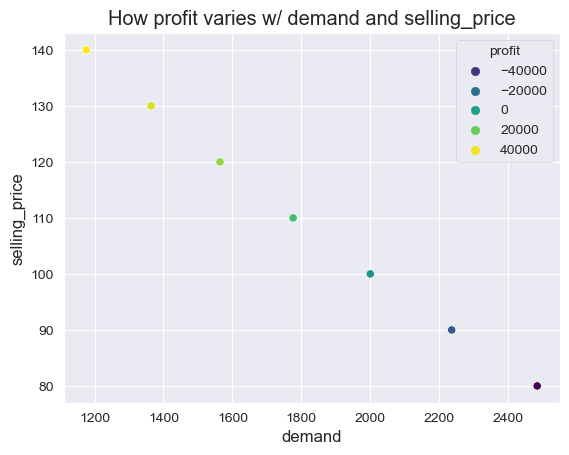

In [160]:
sns.set_style("darkgrid")
sns.scatterplot(x="demand", y="selling_price", hue="profit", data=model_dt1, palette="viridis").set(title='How profit varies w/ demand and selling_price');

In [162]:
# profit_dt_g = sns.FacetGrid(model_dt1, col="demand", sharey=True, col_wrap=2)
# profit_dt_g = profit_dt_g.map(plt.plot, "selling_price", "profit")

**Explanation of graph:**

## 1c - Break Even

In [166]:
model_dt1

,selling_price,profit,demand
0,80,-54680.0,2484.0
1,90,-27360.0,2236.0
2,100,-5000.0,2000.0
3,110,12760.0,1776.0
4,120,26280.0,1564.0
5,130,35920.0,1364.0
6,140,42040.0,1176.0


In [168]:
# Specifying input ranges
dt_param_range1 = {'selling_price': np.arange(80, 141, 10)}

# specifying output
outputs = ['profit', 'demand']

model_goal_dt1 = model.goal_seek('profit', 0, 'selling_price', 80, 141, 1000)
print(f"The Break Even point for this scenario is for selling price to be at: {model_goal_dt1}")

The Break Even point for this scenario is for selling price to be at: 102.57578606424767


In [170]:
# # Initialize plot
# plt.style.use('ggplot')
# fig, ax = plt.subplots()

# # Create series variables
# demand = np.array(model_goal_dt1['demand'])
# selling_price = np.array(model_goal_dt1['selling_price'])
# profit = np.array(model_goal_dt1['profit'])

# # Plot series
# ax.plot(demand, selling_price, label='Selling__Price')
# ax.plot(demand, profit, label='Profit')

# # Style plot elements
# ax.set(title='Break even analysis for bookstore model', xlabel='Demand', ylabel='$')
# plt.hlines(0, 70, 320, linestyles='dotted')
# plt.vlines(break_even_demand, -750, 2000, linestyles='dotted')
# ax.legend(loc='lower right')

# # Show the plot
# plt.show()

## 1d - Two-way Data Table

In [173]:
# Specifying input ranges between $80 and $140
dt_param_range2 = {'selling_price': np.arange(80, 141, 10),
                  'var_cost': np.arange(85, 111, 5)}

# specifying output
outputs = ['profit', 'total_cost']

# Creation of 1-way data table
model_dt2 = model.data_table(dt_param_range2, outputs)
model_dt2

,selling_price,var_cost,profit,total_cost
0,80,85,-17420.0,216140.0
1,80,90,-29840.0,228560.0
2,80,95,-42260.0,240980.0
3,80,100,-54680.0,253400.0
4,80,105,-67100.0,265820.0
5,80,110,-79520.0,278240.0
6,90,85,6180.0,195060.0
7,90,90,-5000.0,206240.0
8,90,95,-16180.0,217420.0
9,90,100,-27360.0,228600.0


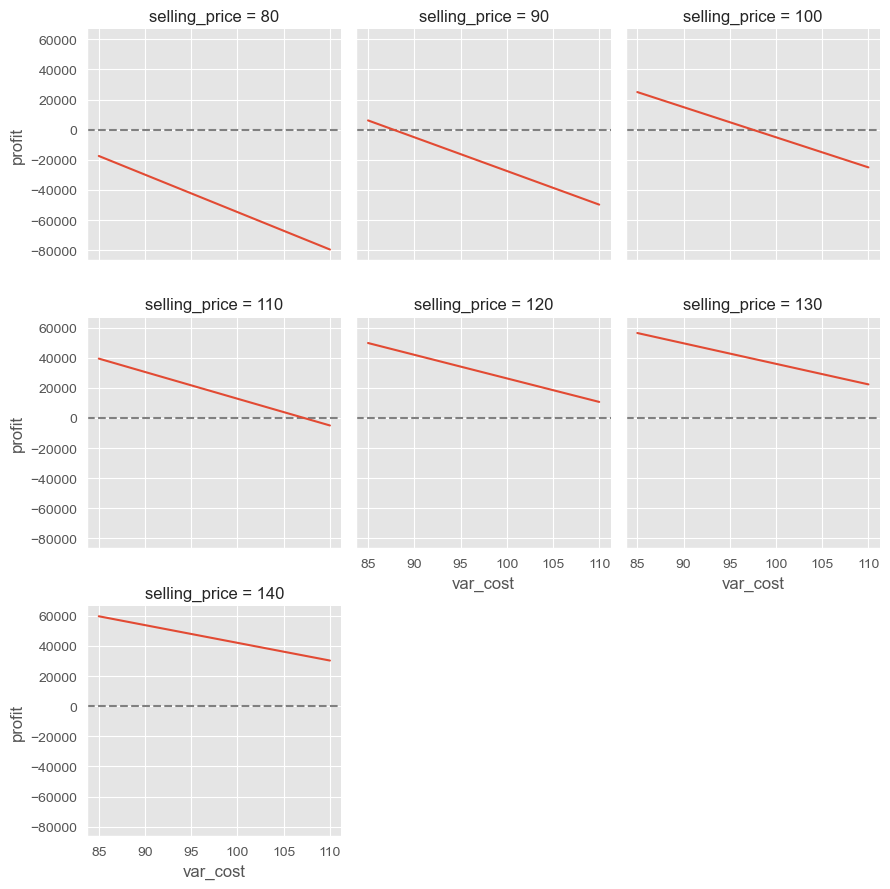

In [216]:
profit_dt_g = sns.FacetGrid(model_dt2, col="selling_price", sharey=True, col_wrap=3).refline(y=0)
profit_dt2 = profit_dt_g.map(plt.plot, "var_cost", "profit")

In [218]:
# # Initialize plot
# plt.style.use('ggplot')
# fig, ax = plt.subplots()

# # Create series variables
# total_cost = np.array(model_dt2['total_cost'])
# var_cost = np.array(model_dt2['var_cost'])
# selling_price = np.array(model_dt2['selling_price'])
# profit = np.array(model_dt2['profit'])

# # Plot series
# #ax.plot(selling_price, total_cost, label='Total cost')
# ax.plot(var_cost, profit, label='Total var cost')
# ax.plot(selling_price, profit, label='Profit')

# # # Style plot elements
# # ax.set(title='Break even analysis for bookstore model', xlabel='Demand', ylabel='$')
# plt.hlines(0, 70, 320, linestyles='dotted')
# #plt.vlines(break_even_demand, -750, 2000, linestyles='dotted')
# ax.legend(loc='lower right')

# # Show the plot
# plt.show()

In [177]:
# model_goal1_dt2 = model.goal_seek('profit', 0, 'selling_price', 80, 141, 1000)
# model_goal2_dt2 = model.goal_seek('total_cost', 0, 'selling_price', 80, 141, 1000)
# model_goal3_dt2 = model.goal_seek('profit', 0, 'var_cost', 85, 111, 1000)
# model_goal4_dt2 = model.goal_seek('total_cost', 0, 'var_cost', 85, 111, 1000)
# print(f"The Break Even point for this scenario is for selling price to be at: {model_goal1_dt2}")
# print(f"The Break Even point for this scenario is for selling price to be at: {model_goal2_dt2}")
# print(f"The Break Even point for this scenario is for selling price to be at: {model_goal3_dt2}")
# print(f"The Break Even point for this scenario is for selling price to be at: {model_goal4_dt2}")

**Explanation:**

## 1e - Digging Deeper

In [224]:
# Specifying input ranges
dt_param_range3 = {'selling_price': np.arange(80, 251, 10)}

# specifying output
outputs = ['profit', 'demand']

# Creation of 1-way data table
model_dt1_again = model.data_table(dt_param_range3, outputs)
model_dt1_again

,selling_price,profit,demand
0,80,-54680.0,2484.0
1,90,-27360.0,2236.0
2,100,-5000.0,2000.0
3,110,12760.0,1776.0
4,120,26280.0,1564.0
5,130,35920.0,1364.0
6,140,42040.0,1176.0
7,150,45000.0,1000.0
8,160,45160.0,836.0
9,170,42880.0,684.0


In [232]:
# Specifying input ranges
dt_param_range3 = {'selling_price': np.arange(80, 251, 10)}

# specifying output
outputs = ['profit', 'demand']

model_goal_extra = model.goal_seek('profit', 0, 'selling_price', 80, 251, 1000)
print(f"The Break Even point for this scenario is for selling price to be at: {model_goal_extra}")

The Break Even point for this scenario is for selling price to be at: None


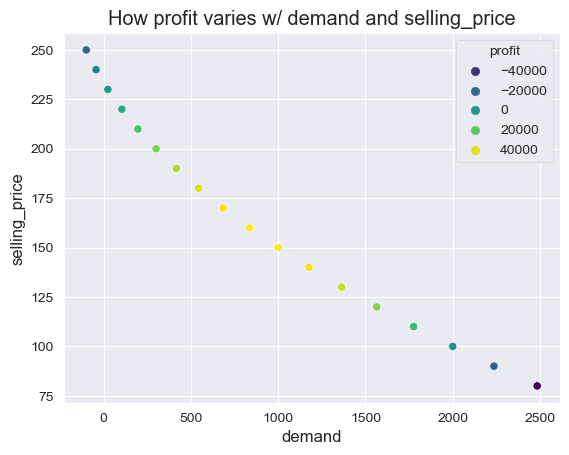

In [234]:
sns.set_style("darkgrid")
sns.scatterplot(x="demand", y="selling_price", hue="profit", data=model_dt1_again, palette="viridis").set(title='How profit varies w/ demand and selling_price');

**Explanation:**

## 1f - Simulation

In [253]:
from numpy.random import default_rng
rg = default_rng(4470)

In [257]:
num_reps = 100

random_inputs = {'var_cost': rg.uniform(80, 120, num_reps)}

scenario_inputs = {'selling_price': np.arange(80, 141, 10)}

sim_outputs = ['profit']

In [263]:
model_simulate = model.simulate(random_inputs, sim_outputs, scenario_inputs)

In [265]:
def get_sim_results_df(results):
    
    dfs = []    
    for r in results:
        df = pd.DataFrame(r['output'])
        df['scenario_num'] = r['scenario_num']
        for key, val in r['scenario_vals'].items():
            df[key] = val
            
        dfs.append(df)

    results_df = pd.concat(dfs)
    
    return results_df

In [267]:
model_results_df = get_sim_results_df(model_simulate)

In [269]:
model_results_df

,profit,scenario_num,selling_price
0,-50562.327290,0,80
1,-19925.613514,0,80
2,-26051.175350,0,80
3,-39043.526957,0,80
4,-97835.214506,0,80
...,...,...,...
95,53903.957141,6,140
96,64067.062224,6,140
97,49326.568539,6,140
98,24750.973733,6,140


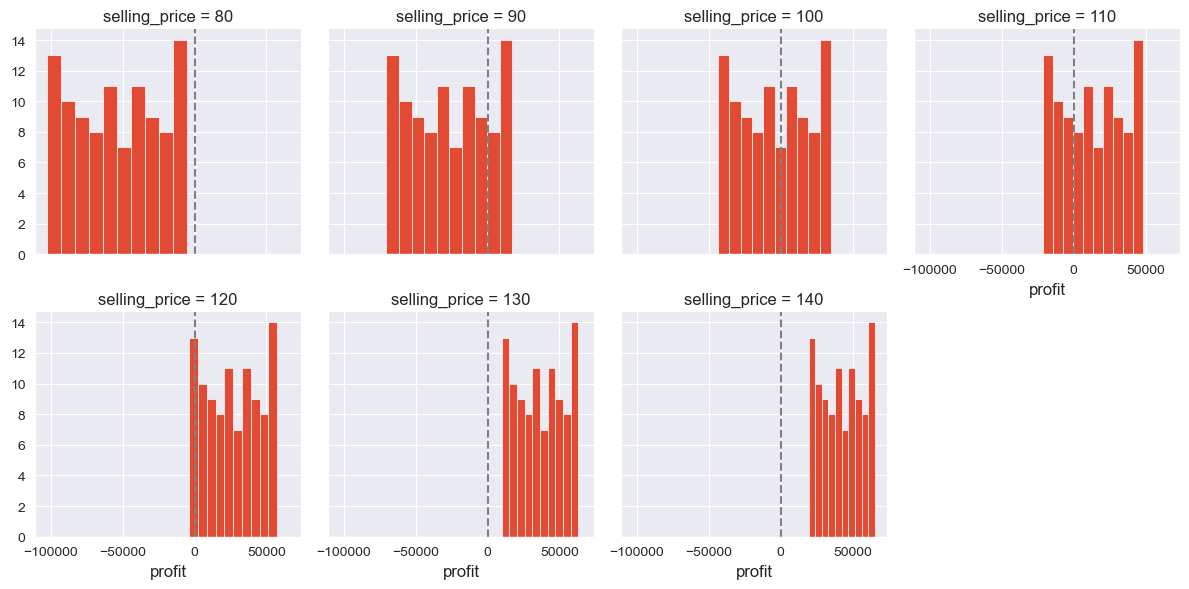

In [275]:
profit_histo_g2 = sns.FacetGrid(model_results_df, col='selling_price', sharey=True, col_wrap=4).refline(x=0)
profit_histo_g2 = profit_histo_g2.map(plt.hist, "profit")

**Explanation:**